In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
from tqdm.notebook import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_user = pd.read_csv('data/user_balance_table.csv')
df_user['report_date'] = df_user['report_date'].apply(lambda x:str(x)[:4] + "-" + str(x)[4:6] + "-" + str(x)[6:] )
df = pd.read_csv('data/complete_feature.csv',index_col = 0)
df['report_date'] = df['date']
# df['report_date'] = df['report_date'].apply(lambda x:str(x)[:4] + "-" + str(x)[4:6] + "-" + str(x)[6:] )
df_time =  df.drop( columns =['total_purchase_amt', 'total_redeem_amt','date'])
rich_id = pd.read_csv('data/user_id_groupby_redeem.csv',index_col = 0)[['user_id','r_3', 'r_4','r_5','r_6']]

In [4]:
df_user = pd.merge(df_user,rich_id,on = ['user_id'],how = 'left')
df_user = pd.merge(df_user,df_time,on = ['report_date'],how = 'left')

In [43]:
user = df_user[['user_id', 'report_date', 'tBalance', 'yBalance', 'total_purchase_amt', 'consume_amt', 'transfer_amt', 'year', 'month', 'week', 'day',
       'weekday', 'is_weekend', 'is_holiday', 'is_lastday_of_holiday',
       'is_work', 'is_gonna_work_tomorrow','r_3', 'r_4', 'r_5','r_6', 'mfd_daily_yield']]

In [44]:
user['t_2'] =  user['report_date'].apply(lambda x:str( (datetime.datetime.strptime(x,"%Y-%m-%d")+datetime.timedelta(2)).date()   )   )  

In [45]:
t_2 = user[['user_id','t_2','tBalance','yBalance','mfd_daily_yield']]
t_2.columns = ['user_id','report_date','t-2tBalance','t-2yBalance','t-2mfd_daily_yield']

In [46]:
user=pd.merge(user,t_2,on = ['user_id','report_date'],how = 'left')

In [ ]:
user_count = user.groupby(['report_date']).count()['user_id'] 
user = pd.merge(user,user_count,on = ['user_id'],how = 'left')

### 划分穷人，筛选出穷人除了利率之外的数据

In [47]:
# b = user.groupby(['user_id']).max()['tBalance'] >0   # 去除非正式用户

In [48]:
the_poor = user[user['r_6'] == 0]
the_poor.shape

(2617704, 26)

In [49]:
len(the_poor.groupby('user_id').count().index)

27206

### Purchase poor

In [189]:
the_poor_purchase = the_poor[the_poor['total_purchase_amt'] > 1000]
the_poor_purchase.shape

(219482, 26)

## remove interest return

In [190]:
the_poor_purchase['pred_yield_lower'] = 10000*the_poor_purchase['total_purchase_amt']/the_poor_purchase['t-2tBalance']
the_poor_purchase['pred_yield_upper'] = 10000*(2+the_poor_purchase['total_purchase_amt'])/the_poor_purchase['t-2tBalance']
filter = 1^(the_poor_purchase['pred_yield_lower'] < 
          the_poor_purchase['mfd_daily_yield'] ) & (the_poor_purchase['pred_yield_upper'] >  the_poor_purchase['mfd_daily_yield'])

In [191]:
the_poor_purchase = the_poor_purchase[filter]

In [192]:
the_poor_purchase.shape

(139643, 28)

In [193]:
the_poor_purchase[(the_poor_purchase['total_purchase_amt'] <2000)].sort_values('report_date')

,user_id,report_date,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,...,r_4,r_5,r_6,mfd_daily_yield,t_2,t-2tBalance,t-2yBalance,t-2mfd_daily_yield,pred_yield_lower,pred_yield_upper
2077205,5183,2013-07-01,0,100068,1941,0,102009,2013,7,27,...,0,0,0,1.5787,2013-07-03,NaN,NaN,NaN,NaN,NaN
739845,21723,2013-07-01,18986,20822,1201,3037,0,2013,7,27,...,0,0,0,1.5787,2013-07-03,NaN,NaN,NaN,NaN,NaN
1660165,20802,2013-07-01,17022,16000,1022,0,0,2013,7,27,...,0,0,0,1.5787,2013-07-03,NaN,NaN,NaN,NaN,NaN
1324784,10804,2013-07-02,1865,0,1865,0,0,2013,7,27,...,0,0,0,1.5461,2013-07-04,NaN,NaN,NaN,NaN,NaN
1289212,9870,2013-07-03,4507,3001,1506,0,0,2013,7,27,...,0,0,0,1.4670,2013-07-05,3001.0,3001.0,1.5787,5018.327224,5024.991669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136536,6957,2014-08-31,0,0,1980,1980,0,2014,8,35,...,1,1,0,1.1204,2014-09-02,0.0,0.0,1.1169,inf,inf
1214685,7787,2014-08-31,16963159,16961389,1770,0,0,2014,8,35,...,0,0,0,1.1204,2014-09-02,15956864.0,15803665.0,1.1169,1.109241,1.110494
2376876,14061,2014-08-31,0,38952,1459,0,40411,2014,8,35,...,0,0,0,1.1204,2014-09-02,90296.0,115716.0,1.1169,161.579693,161.801187
2045056,4283,2014-08-31,9391951,9424286,1055,33390,0,2014,8,35,...,0,0,0,1.1204,2014-09-02,9439819.0,9443758.0,1.1169,1.117606,1.119725


In [194]:
the_poor_purchase[the_poor_purchase['user_id'] == 17309].sort_values('report_date').tail(10)

,user_id,report_date,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,...,r_4,r_5,r_6,mfd_daily_yield,t_2,t-2tBalance,t-2yBalance,t-2mfd_daily_yield,pred_yield_lower,pred_yield_upper
2480445,17309,2014-06-18,0,0,4142,4142,0,2014,6,25,...,0,0,0,1.2244,2014-06-20,0.0,0.0,1.2581,inf,inf
2480646,17309,2014-06-28,0,0,997806,790000,207806,2014,6,26,...,0,0,0,1.1247,2014-06-30,NaN,NaN,NaN,NaN,NaN
2480447,17309,2014-07-02,754573,0,754573,0,0,2014,7,27,...,0,0,0,1.1374,2014-07-04,0.0,0.0,1.1234,inf,inf
2480552,17309,2014-07-19,1009377,14412,994965,0,0,2014,7,29,...,0,0,0,1.1131,2014-07-21,14411.0,14410.0,1.1133,6.904205e+05,6.904219e+05
2480453,17309,2014-07-20,1774453,1009377,1009993,0,244917,2014,7,29,...,0,0,0,1.1129,2014-07-22,14412.0,14411.0,1.1215,7.008000e+05,7.008014e+05
2480556,17309,2014-07-31,590997,20765,980155,200000,209923,2014,7,31,...,0,0,0,1.1156,2014-08-02,20763.0,20761.0,1.1156,4.720681e+05,4.720691e+05
2480457,17309,2014-08-01,0,590997,4642,43200,552439,2014,8,31,...,0,0,0,1.1173,2014-08-03,20765.0,20763.0,1.1162,2.235492e+03,2.236456e+03
2480649,17309,2014-08-02,33335,0,33335,0,0,2014,8,31,...,0,0,0,1.1180,2014-08-04,590997.0,20765.0,1.1156,5.640469e+02,5.640807e+02
2480458,17309,2014-08-04,0,9235,6415,15650,0,2014,8,32,...,0,0,0,1.1451,2014-08-06,33335.0,0.0,1.1180,1.924404e+03,1.925004e+03
2480559,17309,2014-08-27,1395784,0,3650433,2040000,214649,2014,8,35,...,0,0,0,1.1079,2014-08-29,NaN,NaN,NaN,NaN,NaN


In [195]:
# pool_analysis = the_pool[['user_id', 'report_date', 'tBalance','total_purchase_amt', 'consume_amt', 'transfer_amt',
#          'week', 'day', 'weekday', 'is_weekend',
#        'is_holiday', 'is_lastday_of_holiday', 'is_work',
#        'is_gonna_work_tomorrow']]

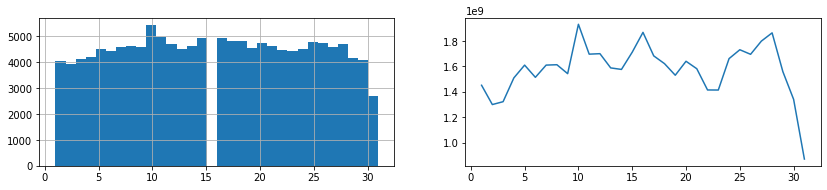

In [196]:
def count_and_sum(df,col,bins,value_col):
    plt.figure(figsize = (14,6))
    plt.subplot(2,2,1)
    df[col].hist(bins = bins)
    plt.subplot(2,2,2)
    plt.plot(df.groupby(col).sum()[value_col])
    plt.show()
count_and_sum(the_poor_purchase,'day',32,'total_purchase_amt')

sample for 每月投入工资党

In [222]:
the_poor_purchase[the_poor_purchase['user_id'] == 25959].sort_values('report_date')

,user_id,report_date,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,...,r_4,r_5,r_6,mfd_daily_yield,t_2,t-2tBalance,t-2yBalance,t-2mfd_daily_yield,pred_yield_lower,pred_yield_upper
1830873,25959,2013-10-29,5088,0,5088,0,0,2013,10,44,...,0,0,0,1.2890,2013-10-31,NaN,NaN,NaN,NaN,NaN
1830762,25959,2013-11-10,35402,5088,30314,0,0,2013,11,45,...,0,0,0,1.2889,2013-11-12,5088.0,5088.0,1.2920,5.957940e+04,5.958333e+04
1830882,25959,2013-12-03,8754,383,8371,0,0,2013,12,49,...,0,0,0,1.3990,2013-12-05,383.0,383.0,1.3876,2.185640e+05,2.186162e+05
1830750,25959,2013-12-10,126752,9062,117690,0,0,2013,12,50,...,0,0,0,1.4271,2013-12-12,8758.0,8757.0,1.3809,1.343800e+05,1.343823e+05
1830860,25959,2013-12-11,162133,126752,35381,0,0,2013,12,50,...,0,0,0,1.4200,2013-12-13,9062.0,8758.0,1.4227,3.904326e+04,3.904546e+04
1830751,25959,2013-12-13,150413,120261,30152,0,0,2013,12,50,...,0,0,0,1.4527,2013-12-15,162133.0,126752.0,1.4200,1.859708e+03,1.859831e+03
1830833,25959,2013-12-29,0,1206,1644,2850,0,2013,12,52,...,0,0,0,1.7886,2013-12-31,6203.0,16220.0,1.8030,2.650330e+03,2.653555e+03
1830846,25959,2014-01-10,304842,0,304842,0,0,2014,1,2,...,0,0,0,1.7878,2014-01-12,NaN,NaN,NaN,NaN,NaN
1830743,25959,2014-01-24,0,305360,2137,0,307497,2014,1,4,...,0,0,0,1.7296,2014-01-26,305307.0,305256.0,1.6853,6.999512e+01,7.006063e+01
1830742,25959,2014-02-11,90320,0,90320,0,0,2014,2,7,...,0,0,0,1.6770,2014-02-13,NaN,NaN,NaN,NaN,NaN


In [210]:
s1 = the_poor_purchase[(the_poor_purchase['day'] == 10) | (the_poor_purchase['day'] == 11)].groupby('user_id').count().sort_values('report_date').iloc[:,0]

In [211]:
s2 = the_poor_purchase.groupby('user_id').count().sort_values('report_date').iloc[:,0]

In [218]:
pd.DataFrame(s1**2/s2).dropna().sort_values('report_date')

,report_date
user_id,
21191,0.015152
16266,0.016667
23633,0.016949
24456,0.018182
6160,0.018868
...,...
21546,3.681818
876,4.000000
3942,4.083333


第一个就是每月十号之前，每个月十号之前就发工资的公司，一般多为国企上市公司和高科技公司等等。第二个时间段是每个月十号到十五号前后，一般部分A股上市公司以及效益比较好的、制度比较健全并且注重管理的公司会在这个时间段发工资。第三个时间段就是十五号以后了

我尝试去找到那个每个月定时把工资投入到余额宝的励志人，25959应该是最接近的了

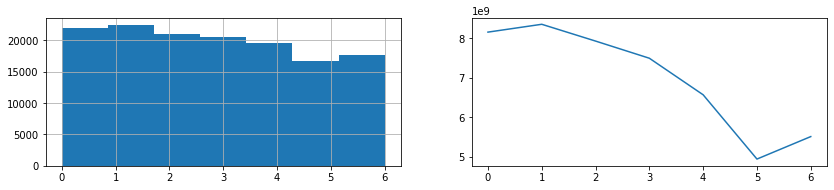

In [199]:
plt.figure(figsize = (14,6))
plt.subplot(2,2,1)
the_poor_purchase['weekday'].hist(bins = 7)
plt.subplot(2,2,2)
plt.plot(the_poor_purchase.groupby('weekday').sum()['total_purchase_amt'])

猜想：根据余额宝的利率设计，在4，5，6投入资金的时候，往往会少了几天的利润

In [119]:
print(the_poor_purchase['is_holiday'].value_counts())
the_poor_purchase.groupby('is_holiday').sum()['total_purchase_amt']

0    197895
1      6405
Name: is_holiday, dtype: int64


is_holiday
0    47913528266
1     1044249625
Name: total_purchase_amt, dtype: int64

happy holiday, 理什么财

## Poor Consume

In [126]:
the_poor_consume =  the_poor[the_poor['consume_amt'] > 0]

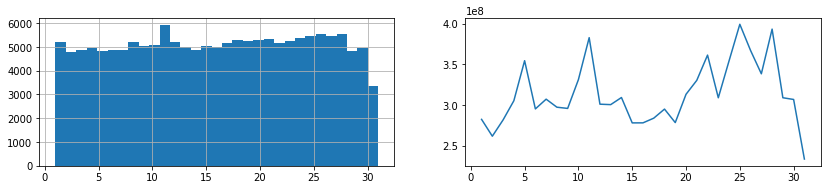

In [164]:
count_and_sum(the_poor_consume,'day',31,'consume_amt' )

10 号， 有工资就花？？？为啥月末时候话得更多？

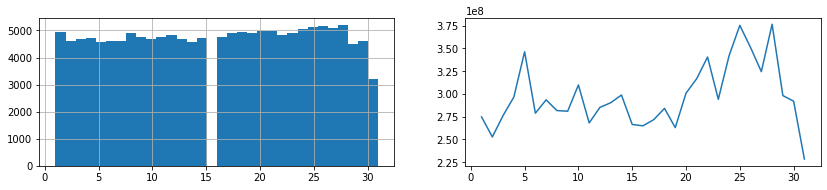

In [223]:
temp = the_poor_consume[(the_poor_consume['month'] != 11)  & (the_poor_consume['month'] != 10) ]
count_and_sum(temp,'day',32,'consume_amt' )

如果去掉11月份和10月份后，11那个烟囱就没了。让我们看看是不是11.11的因素

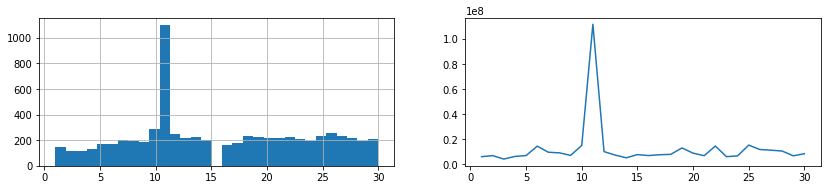

In [167]:
temp = the_poor_consume[(the_poor_consume['month'] == 11)]
count_and_sum(temp,'day',31,'consume_amt' )

果然是双十一，左图的订单贼多，销量也是遥遥领先

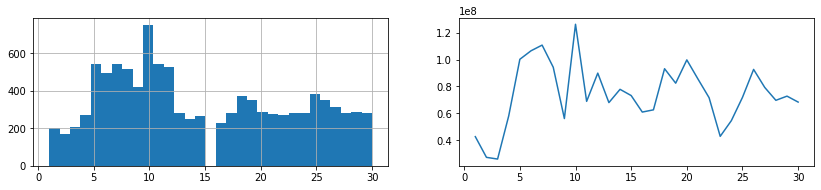

In [171]:
temp = the_poor_purchase[(the_poor_purchase['month'] == 11)]
count_and_sum(temp,'day',31,'total_purchase_amt' )

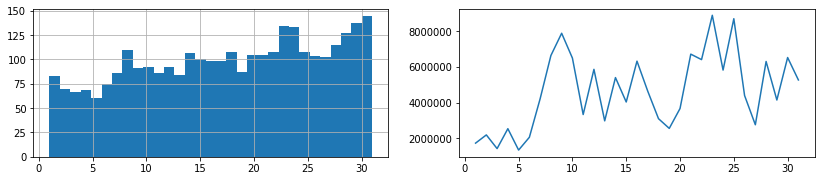

In [168]:
temp = the_poor_consume[(the_poor_consume['month'] == 10)]
count_and_sum(temp,'day',31,'consume_amt' )

10 月份也是平平无奇

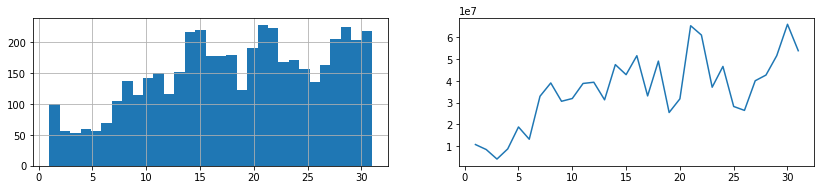

In [170]:
temp = the_poor_purchase[(the_poor_purchase['month'] == 10)]
count_and_sum(temp,'day',31,'total_purchase_amt' )

可以看到双11前有明显的买入行为，伴随着明显的消费行为。

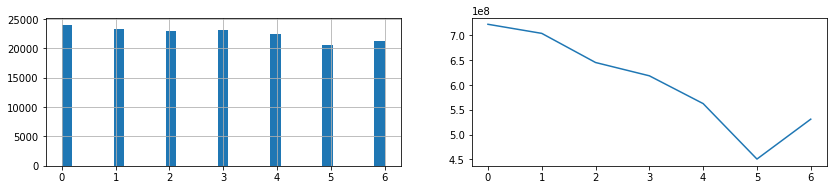

In [158]:
count_and_sum(the_poor_consume,'weekday',31,'consume_amt' )

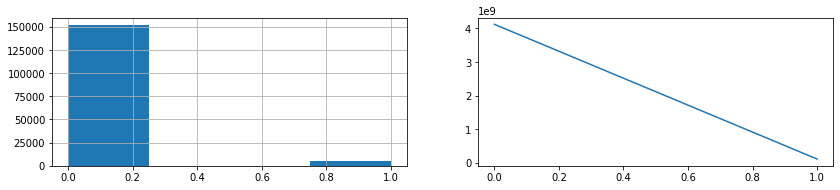

In [135]:
count_and_sum(the_poor_consume,'is_holiday',4,'consume_amt' )

## Poor transform

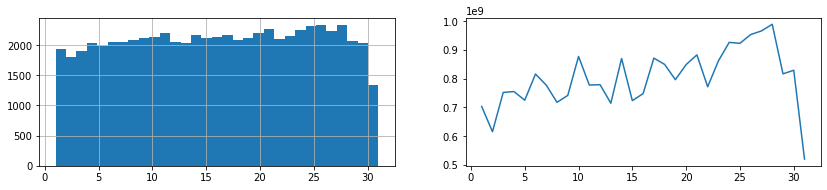

In [224]:
the_poor_transfer =  the_poor[the_poor['transfer_amt'] > 0]
count_and_sum(the_poor_transfer,'day',31,'transfer_amt' )

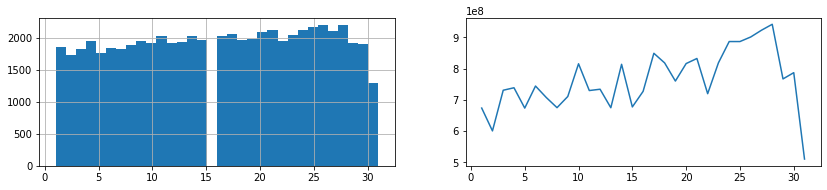

In [228]:
temp = the_poor_transfer[(the_poor_transfer['month'] != 11)  & (the_poor_transfer['month'] != 10) ]
count_and_sum(temp,'day',32,'transfer_amt' )

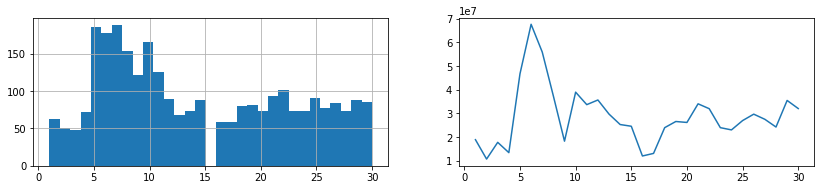

In [229]:
temp = the_poor_transfer[(the_poor_transfer['month'] == 11)]
count_and_sum(temp,'day',31,'transfer_amt' )

transfer 就没有天猫效应了，但是6号就莫名其妙的起来了

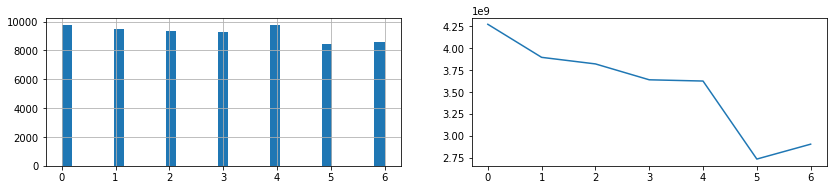

In [231]:
count_and_sum(the_poor_transfer,'weekday',31,'transfer_amt' )

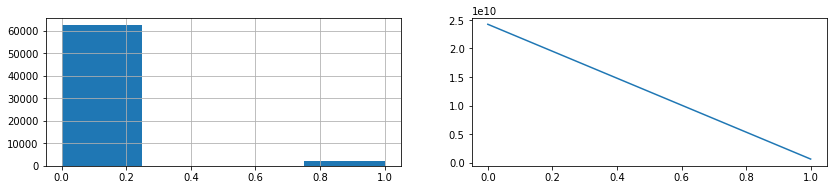

In [232]:
count_and_sum(the_poor_transfer,'is_holiday',4,'transfer_amt' )

In [290]:
the_rich

,user_id,report_date,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,...,is_gonna_work_tomorrow,r_3,r_4,r_5,r_6,mfd_daily_yield,t_2,t-2tBalance,t-2yBalance,t-2mfd_daily_yield
6715,265,2014-02-15,2,2,0,0,0,2014,2,7,...,0,1,1,1,1,1.6566,2014-02-17,2.0,2.0,1.6705
6716,265,2014-02-18,2,2,0,0,0,2014,2,8,...,0,1,1,1,1,1.6433,2014-02-20,2.0,2.0,1.6563
6717,265,2014-02-21,2,2,0,0,0,2014,2,8,...,0,1,1,1,1,1.6282,2014-02-23,2.0,2.0,1.6337
6718,265,2014-02-24,47,2,9947,0,9902,2014,2,9,...,0,1,1,1,1,1.6323,2014-02-26,2.0,2.0,1.6247
6719,265,2014-02-27,47,47,0,0,0,2014,2,9,...,0,1,1,1,1,1.5792,2014-03-01,47.0,47.0,1.6039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840415,28033,2014-08-28,538027,537968,59,0,0,2014,8,35,...,0,1,1,1,1,1.1043,2014-08-30,550707.0,550646.0,1.1085
2840416,28033,2014-08-25,550646,550585,61,0,0,2014,8,35,...,0,1,1,1,1,1.1122,2014-08-27,550525.0,550465.0,1.0997
2840417,28033,2014-08-31,525707,538147,60,12500,0,2014,8,35,...,0,1,1,1,1,1.1204,2014-09-02,538087.0,538027.0,1.1169
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,2014,7,30,...,0,1,1,1,1,1.1215,2014-07-26,20482517.0,20480231.0,1.1166


In [291]:
user[user['user_id'] == 28033]

,user_id,report_date,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,...,is_gonna_work_tomorrow,r_3,r_4,r_5,r_6,mfd_daily_yield,t_2,t-2tBalance,t-2yBalance,t-2mfd_daily_yield
2840238,28033,2014-07-21,20480231,20477892,2339,0,0,2014,7,30,...,0,1,1,1,1,1.1428,2014-07-23,20475614.0,20473336.0,1.1131
2840239,28033,2014-07-18,20473336,20471041,2295,0,0,2014,7,29,...,0,1,1,1,1,1.1215,2014-07-20,20468763.0,20466435.0,1.1377
2840240,28033,2014-07-15,20466435,20464115,2320,0,0,2014,7,29,...,0,1,1,1,1,1.1341,2014-07-17,20461807.0,20459532.0,1.1125
2840241,28033,2014-07-12,20459532,20457256,2276,0,0,2014,7,28,...,0,1,1,1,1,1.1130,2014-07-14,20454966.0,20452655.0,1.1305
2840242,28033,2014-04-01,20403118,20400189,2929,0,0,2014,4,14,...,0,1,1,1,1,1.4368,2014-04-03,20397272.0,20394366.0,1.4257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840415,28033,2014-08-28,538027,537968,59,0,0,2014,8,35,...,0,1,1,1,1,1.1043,2014-08-30,550707.0,550646.0,1.1085
2840416,28033,2014-08-25,550646,550585,61,0,0,2014,8,35,...,0,1,1,1,1,1.1122,2014-08-27,550525.0,550465.0,1.0997
2840417,28033,2014-08-31,525707,538147,60,12500,0,2014,8,35,...,0,1,1,1,1,1.1204,2014-09-02,538087.0,538027.0,1.1169
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,2014,7,30,...,0,1,1,1,1,1.1215,2014-07-26,20482517.0,20480231.0,1.1166


In [287]:
the_poor_consume.groupby('report_date').sum().sort_values('consume_amt',ascending = False).head(20)

,user_id,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,day,...,is_work,is_gonna_work_tomorrow,r_3,r_4,r_5,r_6,mfd_daily_yield,t-2tBalance,t-2yBalance,t-2mfd_daily_yield
report_date,,,,,,,,,,,,,,,,,,,,,
2013-11-11,15153464,684939033,777751950,28705063,111548832,9969148,2216313,12111,50646,12111,...,1101,0,185,134,57,0,1647.3162,7.422175e+08,7.248847e+08,1224.6450
2014-08-31,10296220,1315769793,1387819154,29832104,94586767,7294698,1448066,5752,25165,22289,...,0,0,109,87,37,0,805.5676,1.388505e+09,1.409741e+09,784.0638
2014-08-25,10648848,1427595959,1469047848,56008598,78640489,18819998,1542724,6128,26810,19150,...,766,0,132,94,47,0,851.9452,1.471261e+09,1.475744e+09,828.0741
2014-08-29,10937741,1359597206,1408842043,34901533,74454012,9692358,1498416,5952,26040,21576,...,744,0,119,83,27,0,830.9736,1.403380e+09,1.406284e+09,809.8749
2014-07-22,9388643,1201064437,1270338318,16993645,74325691,11941835,1371534,4767,20430,14982,...,681,0,107,69,33,0,760.4046,1.260408e+09,1.261499e+09,744.5301
2014-08-27,10834069,1498334281,1539555255,47941810,73314538,15848246,1534668,6096,26670,20574,...,762,0,123,87,40,0,844.2198,1.541778e+09,1.541087e+09,834.1500
2014-08-28,10405363,1389040450,1440923247,31034620,72502583,10414834,1446052,5744,25130,20104,...,718,0,109,78,32,0,792.8874,1.448410e+09,1.447478e+09,778.1670
2014-08-26,9640097,1317072699,1358410852,39121542,66573597,13886098,1437996,5712,24990,18564,...,714,0,113,80,43,0,791.4690,1.370944e+09,1.370573e+09,772.8079
2014-06-24,10066989,1314307044,1356957722,32316045,65913622,9053101,1496402,4458,19318,17832,...,743,0,123,92,37,0,882.3125,1.357551e+09,1.374613e+09,861.7836


# 富人

## rich purchase

In [233]:
the_rich = user[user['r_6'] == 1]
the_rich.shape

(222717, 26)

In [330]:
the_rich.groupby('report_date').sum().to_csv(r'data/the_rich.csv')

In [235]:
the_rich_purchase = the_rich[the_rich['total_purchase_amt'] > 1000]


In [236]:
the_rich_purchase['pred_yield_lower'] = 10000*the_rich_purchase['total_purchase_amt']/the_rich_purchase['t-2tBalance']
the_rich_purchase['pred_yield_upper'] = 10000*(2+the_rich_purchase['total_purchase_amt'])/the_rich_purchase['t-2tBalance']
filter = 1^(the_rich_purchase['pred_yield_lower'] < 
          the_rich_purchase['mfd_daily_yield'] ) & (the_rich_purchase['pred_yield_upper'] >  the_rich_purchase['mfd_daily_yield'])

In [238]:
the_rich_purchase = the_rich_purchase[filter]
the_rich_purchase.shape

(34253, 28)

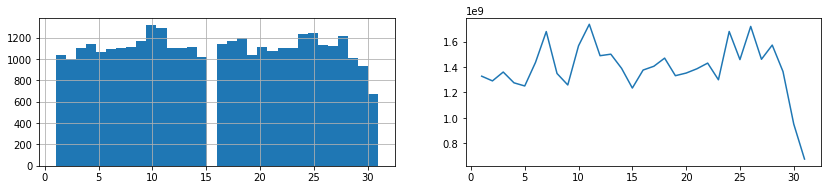

In [239]:
count_and_sum(the_rich_purchase,'day',32,'total_purchase_amt')

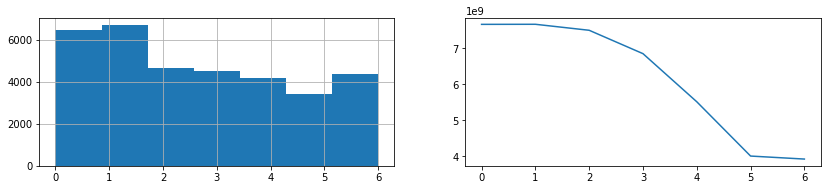

In [241]:
count_and_sum(the_rich_purchase,'weekday',7,'total_purchase_amt')

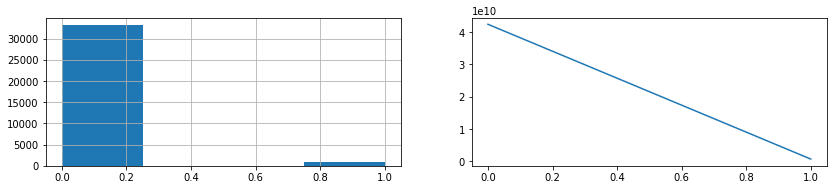

In [242]:
count_and_sum(the_rich_purchase,'is_holiday',4,'total_purchase_amt')

## Rich Consume

In [243]:
the_rich_consume =  the_rich[the_rich['consume_amt'] > 0]

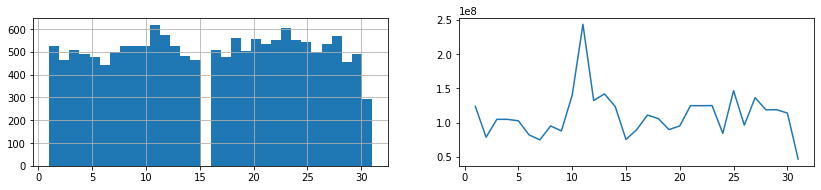

In [244]:
count_and_sum(the_rich_consume,'day',32,'consume_amt' )

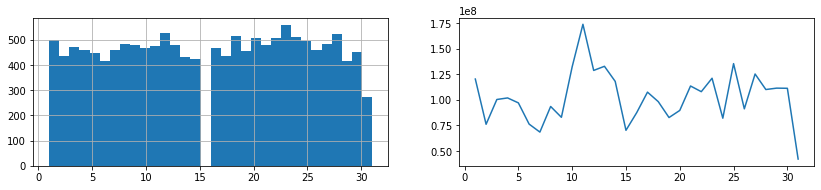

In [245]:
temp = the_rich_consume[(the_rich_consume['month'] != 11)  & (the_rich_consume['month'] != 10) ]
count_and_sum(temp,'day',32,'consume_amt' )

剔除掉了双十一的影响，富人们的交易数量大致确定下来了。但是10月份结尾的订单总额还是高于其他

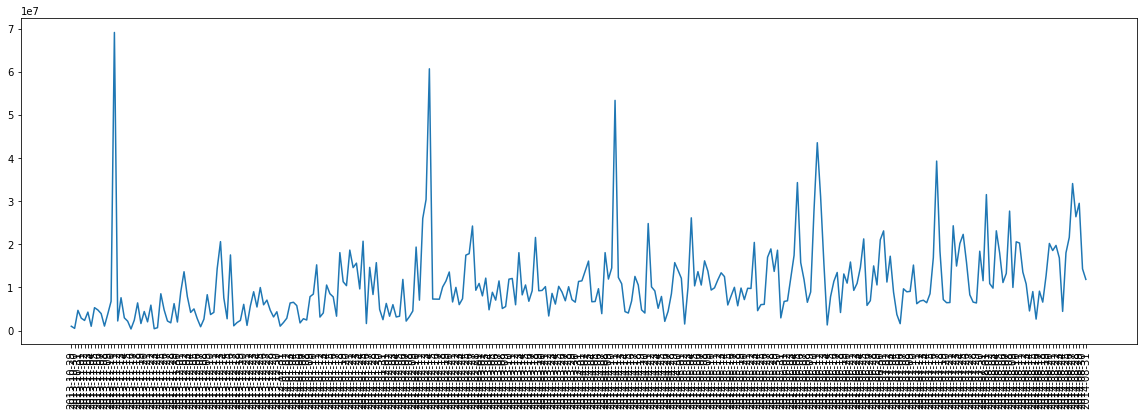

In [272]:
plt.figure(figsize = (20,6))
plt.plot(the_rich_consume.groupby('report_date').sum().iloc[120:,[4]])
plt.xticks(rotation=90)
plt.show()

In [295]:
the_rich_consume[the_rich_consume["report_date"] == '2013-11-11'].sort_values('consume_amt')

,user_id,report_date,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,...,is_gonna_work_tomorrow,r_3,r_4,r_5,r_6,mfd_daily_yield,t_2,t-2tBalance,t-2yBalance,t-2mfd_daily_yield
1792005,24763,2013-11-11,923702,923695,107,100,0,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,923603.0,717836.0,1.2891
1300078,10141,2013-11-11,626760,626785,93,118,0,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,626705.0,1544184.0,1.2891
1951082,1533,2013-11-11,1572359,5190422,776,400,3618439,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,5189754.0,5189086.0,1.2891
134314,3897,2013-11-11,188904,189626,28,750,0,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,189636.0,189636.0,1.2891
1348935,11533,2013-11-11,103126,103931,15,820,0,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,103918.0,103905.0,1.2891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748316,21985,2013-11-11,4100453,3040501,2998063,1938111,0,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,3040110.0,3039719.0,1.2891
2659185,22690,2013-11-11,32879945,38924383,995763,4999900,2040301,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,38919943.0,34460192.0,1.2891
2503280,18036,2013-11-11,261630,5808534,854,5547758,0,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,5807799.0,5738930.0,1.2891
200169,5905,2013-11-11,5473672,20470825,2847,15000000,0,2013,11,46,...,0,1,1,1,1,1.4962,2013-11-13,19037840.0,19035387.0,1.2891


In [255]:
the_rich_consume.groupby('report_date').sum().sort_values('consume_amt',ascending = False).head(20)

,user_id,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,day,...,is_work,is_gonna_work_tomorrow,r_3,r_4,r_5,r_6,mfd_daily_yield,t-2tBalance,t-2yBalance,t-2mfd_daily_yield
report_date,,,,,,,,,,,,,,,,,,,,,
2013-11-11,1824299,684441703,739223482,23597583,69106654,9272708,265716,1452,6072,1452,...,132,0,132,132,132,132,197.4984,736557671.0,703340902.0,159.8484
2014-02-14,615870,429448532,476469631,25183725,60687601,11517223,82574,82,287,574,...,41,0,41,41,41,41,68.1010,475002624.0,472505285.0,66.8080
2014-04-11,888604,684879155,774756343,9557364,53368681,46065871,120840,240,900,660,...,60,0,60,60,60,60,84.6360,764784949.0,807231164.0,82.5862
2014-06-11,783410,900761774,887216959,62026542,43555204,4926523,124868,372,1488,682,...,62,0,62,62,62,62,78.8826,892646461.0,884099816.0,78.8578
2014-07-17,711325,398166990,450732363,10430733,39297728,23698378,112784,392,1624,952,...,56,0,56,56,56,56,62.3448,452773442.0,449127782.0,63.5096
2014-06-05,660803,423637427,495639896,12173928,34316894,49859503,94658,282,1081,235,...,47,0,47,47,47,47,60.2446,502112650.0,483904914.0,58.6231
2014-08-27,979386,553232635,601085983,9827275,34093633,23586990,145008,576,2520,1944,...,72,0,72,72,72,72,79.7688,583800056.0,594378619.0,80.0784
2014-08-01,1038559,743584548,752464432,36063969,31530055,13413798,157092,624,2418,78,...,78,0,78,78,78,78,87.1494,744941287.0,727756344.0,87.0636
2014-06-12,1053063,874424252,906453085,10300865,31047501,11282197,130910,390,1560,780,...,65,0,65,65,65,65,82.0625,895060508.0,894213415.0,82.0820


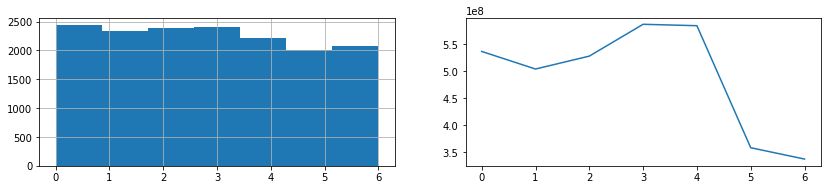

In [273]:
count_and_sum(the_rich_consume,'weekday',7,'consume_amt' )

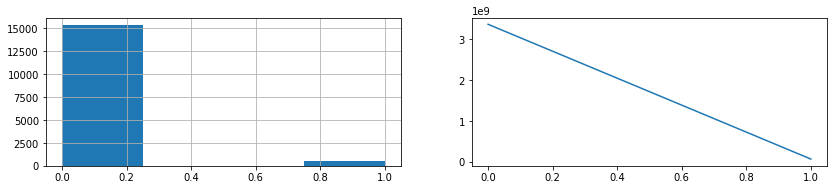

In [274]:
count_and_sum(the_rich_consume,'is_holiday',4,'consume_amt' )

## rich transfer

In [275]:
the_rich_transfer =  the_rich[the_rich['transfer_amt'] > 0]

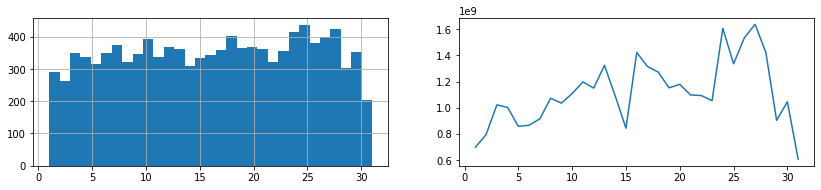

In [278]:
count_and_sum(the_rich_transfer,'day',31,'transfer_amt' )

数量大致相同，但是数额的形状太奇怪了

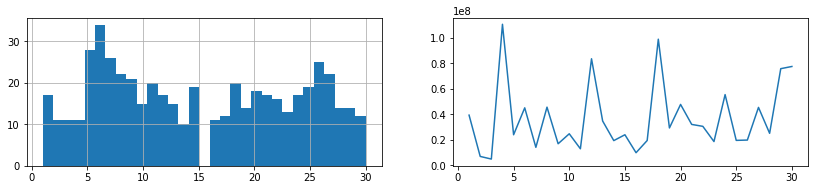

In [280]:
temp = the_rich_transfer[(the_rich_transfer['month'] == 11)]
count_and_sum(temp,'day',31,'transfer_amt' )

rich 也没有天猫效应了

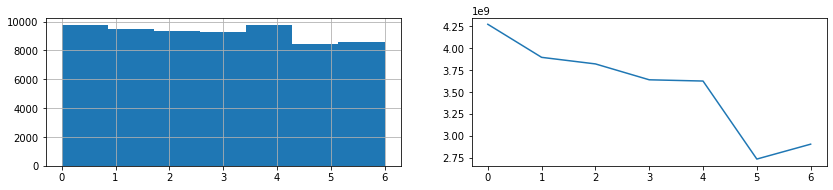

In [281]:
count_and_sum(the_poor_transfer,'weekday',7,'transfer_amt' )

week依旧是周末贼低

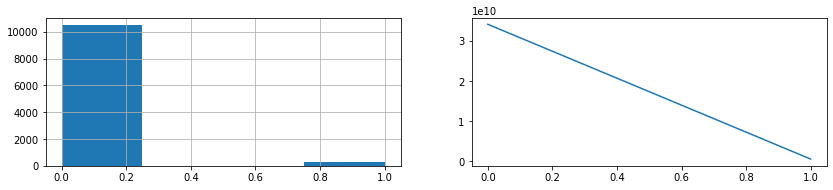

In [283]:
count_and_sum(the_rich_transfer,'is_holiday',4,'transfer_amt' )

In [312]:
# 会有大额资金流向嘛？
temp = user[user['consume_amt'] > 60000]
# temp['consume_amt'].sort_values()[int(0.8*len(temp)):].value_counts()

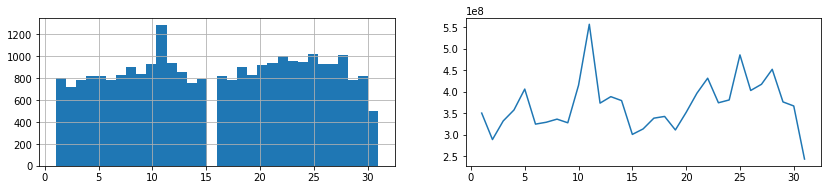

In [314]:
count_and_sum(temp,'day',32,'consume_amt' )

wow!!! 大额消费竟然在11号更容易发生！让我们看看是不是天猫

In [315]:
temp = temp[temp['report_date'] != '2013-11-11']

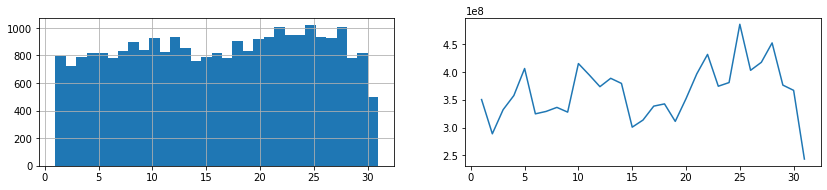

In [318]:
count_and_sum(temp,'day',31,'consume_amt' )

果然是因为天猫多了很多订单！就根据订单的数量而言，并没有什么特别的

## Conclusion


In [325]:
the_poor

,user_id,report_date,tBalance,yBalance,total_purchase_amt,consume_amt,transfer_amt,year,month,week,...,is_gonna_work_tomorrow,r_3,r_4,r_5,r_6,mfd_daily_yield,t_2,t-2tBalance,t-2yBalance,t-2mfd_daily_yield
0,1,2014-08-05,20385,20383,2,0,0,2014,8,32,...,0,0,0,0,0,1.1203,2014-08-07,20381.0,20379.0,1.1178
1,1,2014-08-08,20391,20389,2,0,0,2014,8,32,...,0,0,0,0,0,1.1397,2014-08-10,20387.0,20385.0,1.1162
2,1,2014-08-11,20397,20395,2,0,0,2014,8,33,...,0,0,0,0,0,1.1235,2014-08-13,20393.0,20391.0,1.1173
3,1,2014-08-14,20403,20401,2,0,0,2014,8,33,...,0,0,0,0,0,1.1367,2014-08-16,20399.0,20397.0,1.1146
4,1,2014-08-17,20409,20407,2,0,0,2014,8,33,...,1,0,0,0,0,1.1126,2014-08-19,20405.0,20403.0,1.1129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840234,28019,2013-12-07,8243,8242,1,0,0,2013,12,49,...,0,0,0,0,0,1.3815,2013-12-09,8241.0,8240.0,1.4025
2840235,28019,2013-12-04,8240,8239,1,0,0,2013,12,49,...,0,0,0,0,0,1.3982,2013-12-06,8238.0,8237.0,1.3882
2840236,28019,2013-11-29,8235,8234,1,0,0,2013,11,48,...,0,0,0,0,0,1.3879,2013-12-01,8233.0,8232.0,1.3755
2840237,28019,2013-12-01,8237,8236,1,0,0,2013,12,48,...,1,0,0,0,0,1.3876,2013-12-03,8235.0,8234.0,1.3879
